# Covid-19 Analysis with BastionLab

In this tutorial, we are going to explore how we can use BastionLab to explore a Covid-19 dataset.

## Pre-requisites

### Technical Requirements

To start this tutorial, ensure the following are already installed in your system:
- Python3.7 or greater (get the latest version of Python at https://www.python.org/downloads/ or with your operating system’s package manager)
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager
- [Docker](https://www.docker.com/) 

*Here's the [Docker official tutorial](https://docker-curriculum.com/) to set it up on your computer.*

## Pip packages and dataset

In order to run this notebook, you will also need to install Polars, Bastionlab which you can do by running the code block below. Finally, you will need to download the dataset we will be using in this tutorial from Kaggle by following this link: https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset and creating a free user account. You then need to move the "covid_19_data.csv" file into this folder. This dataset is a WHO dataset, compiling worldwide statitics related to cases of Covid-19 around the globe.

In [36]:
! pip install polars
! pip install bastionlab

## Getting set-up


Next, we'll install and launch the server. For testing purposes, BastionLab server has been packaged as a pip wheel. In this tutorial, we will use this package to quickly set up a test server.

In [37]:
!pip install bastionlab_server

The server exposes port 50056 for gRPC communication with clients and uses a default configuration (no authentication, default settings). For the purpose of this Tour, these settings are sufficient and we won't change them.

To run the server, we use the utility function provided by the bastionlab_server package.

In [ ]:
import bastionlab_server

srv = bastionlab_server.start()

Now that's all done, we can finally connect to our server, send over our CSV file and start analysing our data!

Firstly, we read in the dataset using Polar's read_csv() function, which returns a Polar's DataFrame instance containing the dataset.
Secondly, we connect to the server using Bastionlab's Connection() method.

In [38]:
from bastionlab import Connection
import polars as pl

df = pl.read_csv("covid_19_data.csv")

connection = Connection("localhost", 50056)

Finally, we send the Polar's DataFrame instance to the server using Bastionlab's send_df() method which will return a RemoteLazyFrame instance, a reference to the DataFrame uploaded which we will be working with throughout this tutorial. For the sake of this tutorial, we specify an unsafe policy which disables the need for the data owner to approve any requests that don't pass our data safety rules. This is purely done so that we can focus on demonstrating data cleaning and analysis in BastionLab without having to worry about approving any data access requests.

We then create a custom policy which disables all data request/query checks. We do this creating a policy where the `safe_zone` parameter to `TrueRule()` to allow all requests. In this case, the `unsafe_handling` parameter can be anything (as there are no unsafe requests), we set it to `Log()` in the following example. Note that this is purely done so that we can focus on demonstrating our visualization functions in this tutorial, but this policy is not suited for production.

In [39]:
from bastionlab.polars.policy import Policy, TrueRule, Log

policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log())
rdf = connection.client.polars.send_df(df, policy=policy)

We can now see the list of column names in the dataset by using RemoteDataFrame's columns() method.

In [40]:
rdf.columns

['SNo',
 'ObservationDate',
 'Province/State',
 'Country/Region',
 'Last Update',
 'Confirmed',
 'Deaths',
 'Recovered']

# Data cleaning: Null values

Firstly, we want to see where we might have problems with missing values in our dataset, so we will calculate what percentage of values are missing from each column by taking the sum of is_null() values in each column, multiplying them by 100 and dividing them by the total rows of that same column.

In order to make this tutorial easier to follow, we will print out the results of our query using the .collect() and .fetch() methods necessary to transform the RemoteLazyFrame instance to a readable dataset. This would ordinarily require the request to be confirmed by the dataset owner, but in this case, we have disabled the data access approval feature.

In [41]:
percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,25.487144,0.0,0.0,0.0,0.0,0.0


We can see that there are quite a lot of null values in the Province/State column. Let's change these null values to "Uknown" by selecting the column 'Province/State' and using the fill_null() method to fill null values with a value of our choice- "Unknown" in this case.

To check this has worked, we can output the total sum of null values in the 'Province/State' column- we can see this is now 0.

In [42]:
rdf = rdf.with_column(pl.col("Province/State")).fill_null("Unknown")
total_nulls = rdf.select(pl.col("Province/State").is_null().sum())
total_nulls.collect().fetch()

Province/State
u32
0


# Data cleaning: Column dtypes
Next, we want to check if the column dtypes are the best fit for our dataset. We can list the dtypes by printing out the schema attribute on our RemoteLazyFrame which outputs all column names and dtypes. 

In [43]:
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Utf8,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Last Update': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Float64,
 'Deaths': polars.datatypes.Float64,
 'Recovered': polars.datatypes.Float64}

We can see that the dtype of the 'Confirmed', 'Deaths' and 'Recovered' columns is f64. We can change this to Int64 using the .cast(pl.Int64) method as we should only have integer values in these columns. We combine this with the with_columns() method to place these new columns into our RemoteLazyFrame, effectively replacing the old ones.

We will also convert the 'ObservationDate' column to a pl.Date type so that we can more easily run queries against the months, days and years within the date. To do this, I need to specify the format the dates are written in. This will therefore not work if you have dates in mixed formats, in which case, you would need to clean up the data before calling this function.

Finally, we will drop the 'Last Update' column as we won't be needing it for the purposes of this tutorial and because this column contains a mix of date formats which can take time to clean and our beyong the scope of this tutorial. However, feel free to get in touch and let us know if you'd like to see a tutorial on this topic, or any other, via our Discord community!

In [44]:
rdf = rdf.with_columns(
    pl.col(x).cast(pl.Int64, strict=True) for x in ["Confirmed", "Deaths", "Recovered"]
)
rdf = rdf.with_column(
    pl.col("ObservationDate").str.strptime(pl.Date, fmt="%m/%d/%Y", strict=False)
)
rdf = rdf.drop("Last Update")
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Date,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Int64,
 'Deaths': polars.datatypes.Int64,
 'Recovered': polars.datatypes.Int64}

As you can see our changes have been taken into account as expected.

## Replacing alternative labels with one unique label

By quickly looking over the .csv file, we can also see that we have both "China" and "Mainland China" values in the Country/Region column. We want to group all these values under one label, "China". We can do this using the .when.then.otherwise() methods.

To check this has worked, we can print out the sum of unique values in the Country/region column before and after this change. We can see it reduces by one after we replace "Mainland China" values with "China".

In [45]:
test = (
    rdf.select(pl.col("Country/Region"))
    .unique()
    .select(pl.col("Country/Region").count())
)
print(test.collect().fetch())

rdf = rdf.with_column(
    pl.when(pl.col("Country/Region") == "Mainland China")
    .then("China")
    .otherwise(pl.col("Country/Region"))
    .alias("Country/Region")
)

test = (
    rdf.select(pl.col("Country/Region"))
    .unique()
    .select(pl.col("Country/Region").count())
)
print(test.collect().fetch())

shape: (1, 1)
┌────────────────┐
│ Country/Region │
│ ---            │
│ u32            │
╞════════════════╡
│ 229            │
└────────────────┘
shape: (1, 1)
┌────────────────┐
│ Country/Region │
│ ---            │
│ u32            │
╞════════════════╡
│ 228            │
└────────────────┘


## Adding new columns

We also want to add a new column "Active_cases", which will be calculated as following: Confirmed - Deaths - Recovered. We can do this, again, using the with_column method with the .when.then.otherwise() methods.


In [46]:
rdf = rdf.with_column(
    (pl.col("Confirmed") - pl.col("Deaths") - pl.col("Recovered")).alias("Active_cases")
)
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Date,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Int64,
 'Deaths': polars.datatypes.Int64,
 'Recovered': polars.datatypes.Int64,
 'Active_cases': polars.datatypes.Int64}

## Data Analysis

So now the dataset has been cleaned and prepared, let's start to analyse the data. let's run a query to get the total of confirmed cases, deaths, number of people recovered and active cases worldwide. For the sake of simplicity, we will only look at the latest data provided by countries on the most recent observation date. A small number of countries did not submit obersvations on this day and will therefore not be included in these results, but the data is sufficent for the sake of this tutorial.

We can display the results by using the .collect() and .fetch() in combination to get a printable version of our dataframe.

With default or stricter privacy policies, when you want to .collect().fetch() a RemoteLazyFrame, the query will be screened to check that data is sufficiently anonymous and if this is not the case, data access approval from the data owner will be needed.

In our case, this query does not pose a data privacy risk because we are extracting the results of an aggregated query which does not reveal any specific data relating to an individual- but in any case, we have disabled this feature for this tutorial.

In [47]:
from datetime import date

latest_date = date(2021, 5, 28)  # create DateTime value: 2021-05-28
cols = ["Deaths", "Confirmed", "Recovered", "Active_cases"]

total = rdf.filter(
    pl.col("ObservationDate") == latest_date
).select(  # limit to data shared on this observation date
    [pl.col(x).sum() for x in cols]
)  # get the sum of values shared on this date for each category in cols
total.collect().fetch()

Deaths,Confirmed,Recovered,Active_cases
i64,i64,i64,i64
3523117,169470725,106633069,59314539


Let's now take a look at the top 10 countries in terms of confirmed Covid cases in the dataset. To do this, we can run a similar query to the previous one but will group the data by country before summing the values for each catgeory on the selected date.

We then limit this dataframe to the highest ten results and collect().fetch() the results.

In [48]:
all_cols = ["Deaths", "Confirmed", "Recovered", "Active_cases", "Country/Region"]
agg_cols = ["Deaths", "Confirmed", "Recovered", "Active_cases"]

by_country = (
    rdf.filter(
        pl.col("ObservationDate") == latest_date
    )  # limit to data shared on this observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Country/Region"))  # group data by country
    .agg(
        [pl.col(x).sum() for x in agg_cols]
    )  # get the sum of values shared by each country on this date for each category in agg_cols
)

top_10 = (
    by_country.select([pl.col("Country/Region"), pl.col("Confirmed")])
    .sort(pl.col("Confirmed"), reverse=True)
    .limit(10)
)
top_10.collect().fetch()

Country/Region,Confirmed
str,i64
"""US""",33239963
"""India""",27729247
"""Brazil""",16391930
"""France""",5708350
"""Turkey""",5228322
"""Russia""",4986458
"""UK""",4493582
"""Italy""",4209707
"""Argentina""",3702422


## Barplot visualizations

We can now easily visualize out top_10 RemoteLazyFrame this using the `barplot` function.

We then simply supply the x and y columns as arguments to the barplot() function to get our bar chart visualization.

I then use matplotlib pyplot's `xticks` function to rotate the x axes labels by 60 degrees to avoid them overlapping.

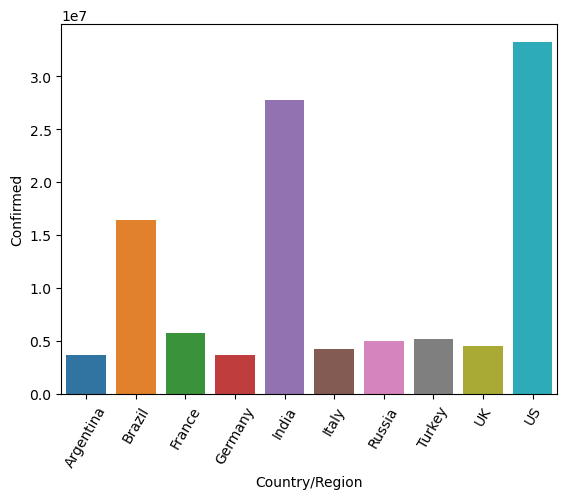

In [49]:
top_10.barplot(y="Confirmed", x="Country/Region")

import matplotlib.pyplot as plt

plt.xticks(rotation=60)
plt.show()

Next, we can have a look at the evolution of confirmed covid cases in a specific country over a specific time frame. Let's take the UK cases in 2020 as our example this time.

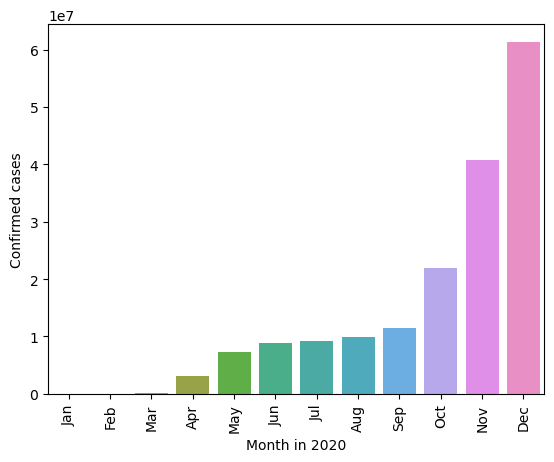

In [71]:
# get UK 2020 only dataframe and group by month
UK = (
    rdf.filter(
        (pl.col("Country/Region") == "UK")
        & (pl.col("ObservationDate").dt.year() == 2020)
    )
    .groupby(pl.col("ObservationDate").dt.month())
    .agg(pl.col("Confirmed").sum())
    .sort(pl.col("ObservationDate"))
)

UK.barplot(x="ObservationDate", y="Confirmed")
# set x and y labels
plt.ylabel("Confirmed cases")
plt.xlabel("Month in 2020")

# Set x axis labels and totates X-Axis labels by 90 degrees
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=90,
)
plt.show()

## Pie Chart Visualizations

Next, we will display patient outcomes globally as a pie chart using the `pieplot` function.

However, before we call `pieplot`, we first need to do a couple of small preparation steps. Firstly, we select only deaths, recovered and active cases as these are the segments we want to include in our pie chart. And secondly, we need to flip our `total` RemoteLazyFrame from wide to long form, using Polar's `melt` function as shown below.

In [ ]:
selects = ["Deaths", "Active_cases", "Recovered"]
flipped = total.select(pl.col(x) for x in selects).melt()
flipped.collect().fetch()

variable,value
str,i64
"""Deaths""",3523117
"""Active_cases""",59314539
"""Recovered""",106633069


Now, that that is done, we can simply call pieplot on our `flipped` RemoteLazyFrame to get a pie chart of this data.

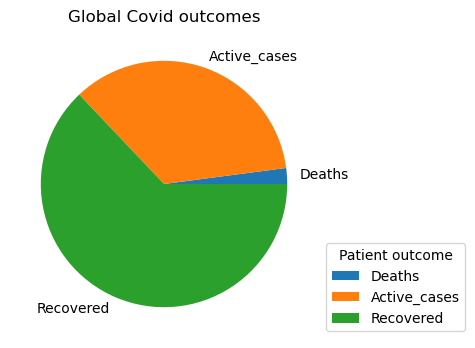

In [ ]:
flipped.pieplot(
    parts="value",
    labels="variable",
    title="Global Covid outcomes",
    key_title="Patient outcome",
    key_loc="lower right",
)

Now let's imagine we want to see the outcomes just for patients from France, Spain and Germany. Firstly we will filter down the by_country RemoteLazyFrame instance to only contain data relating to France, Germany and Spain and then we will collect().fetch() this dataframe.

In [ ]:
compare = by_country.filter(
    (pl.col("Country/Region") == "France")
    | (pl.col("Country/Region") == "Germany")
    | (pl.col("Country/Region") == "Spain")
).sort(pl.col("Country/Region"))
compare.collect().fetch()

Country/Region,Deaths,Confirmed,Recovered,Active_cases
str,i64,i64,i64,i64
"""France""",109452,5708350,390196,5208702
"""Germany""",88360,3680159,3472650,119149
"""Spain""",79905,3668658,150376,3438377


So next, we will create a figure comparing the deaths, recovered and active cases in these three countries. This example illustrates how you can work with both our pieplot function and matplotlib pyplot to modify the output you will get from this function.

In this example, instead of letting the pieplot function take care of creating our axis, we create our own fig and ax variables using matplotlib pyplot's subplots function in order to create a grid with three columns, one for each of the three pieplot's we will display. 

We then use a for loop to iterate over each column in our grid, create the dataframe needed for each country's pie chart and send our axis indexed to the correct column to get the following output.

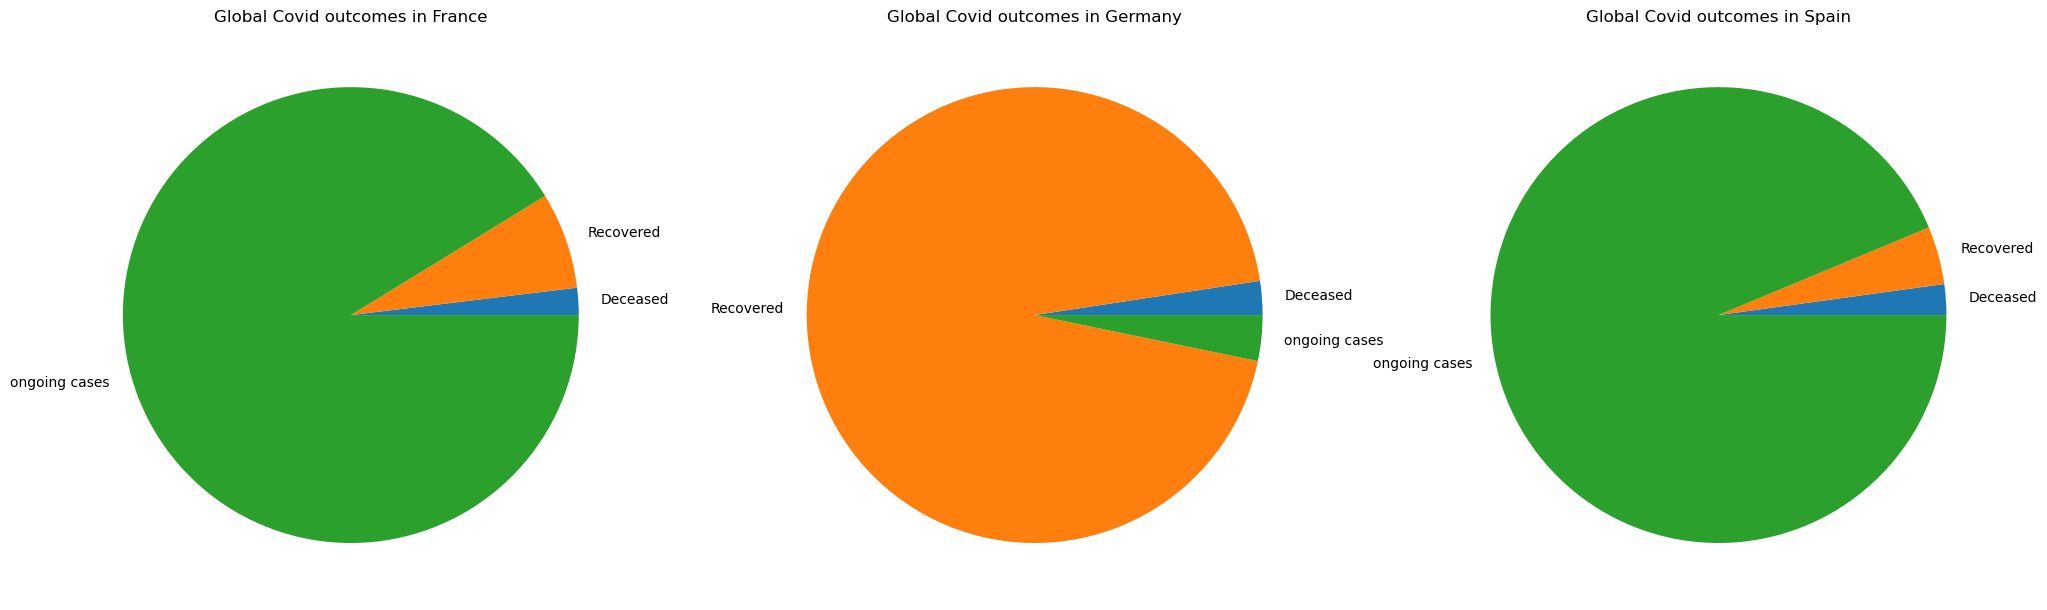

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 20))
countries = ["France", "Germany", "Spain"]

count = 0
for i in range(3):
    pie = (
        compare.filter(pl.col("Country/Region") == countries[i])
        .select(pl.col(x) for x in ["Deaths", "Recovered", "Active_cases"])
        .melt()
    )
    pie.pieplot(
        parts="value",
        labels=["Deceased", "Recovered", "ongoing cases"],
        title="Global Covid outcomes in " + countries[i],
        key=False,
        ax=ax[i],
    )
plt.show()

Let's now take a look at confirmed cases by Province/State in Belgium. We will create a fresh RemoteLazyFrame instance based on the original dataset to do this. We will first filter the data down to data released by Belgium on the latest ObservationDate and then group data this time by Province/State before collecting the sum of confirmed cases.

In [ ]:
all_cols = ["Confirmed", "Province/State"]

belgium = (
    rdf.filter(
        (pl.col("Country/Region") == "Belgium")
        & (pl.col("ObservationDate") == latest_date)
    )  # limit data to data shared by Spain on the latest observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Province/State"))  # group data by province/state
    .agg(pl.col("Confirmed").sum())  # get the sum of confirmed cases
)
belgium.collect().fetch()

Province/State,Confirmed
str,i64
"""Flemish Braban...",80513
"""West Flanders""",95532
"""East Flanders""",121450
"""Hainaut""",156176
"""Luxembourg""",30816
"""Walloon Braban...",40499
"""Unknown""",20183
"""Brussels""",129836
"""Namur""",58466


Now we have this dataframe, we can make a donut chart displaying the percentage of cases in each region. To do this, we will simply create a pie chart using the `pieplot` function and then add a white circle over the pie chart using matplotlib's `add_artist` to create a donut effect.

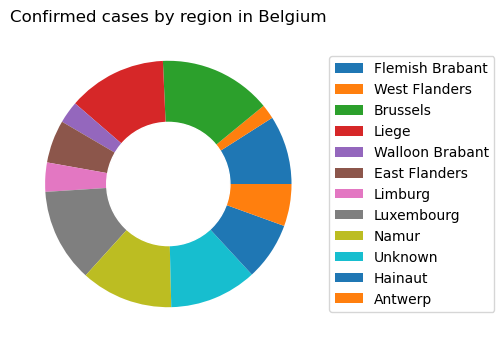

In [ ]:
belgium.pieplot(
    parts="Confirmed",
    labels="Province/State",
    pie_labels=False,
    title="Confirmed cases by region in Belgium",
)
my_circle = plt.Circle((0, 0), 0.5, color="white")  # create a white circle

# Get current pie chart figure using gcf() function and add white circle to it
fig = plt.gcf()
fig.gca().add_artist(my_circle)

# Display donut
plt.show()

So that brings our demo to an end. All that's left to do is close our connection!

In [ ]:
connection.close()